In [4]:
import json
import os
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfb = tfp.bijectors
from bakeoff.TensorFlow_Prob.run_tfp import make_conditioned_lp

In [ ]:
def poisson(n_samples, lambda_like=2.0, seed=20):
    np.random.seed(seed)
    data = np.random.poisson(lambda_like, n_samples)
    return data

def load_config(config_file="config.json"):
    with open(config_file, 'r') as f:
        config = json.load(f)
    return config

def pushforward_exp_mean_std(mu, sigma):
    mu = float(np.asarray(mu).squeeze())
    sigma = float(np.asarray(sigma).squeeze())
    if sigma < 0:
        raise ValueError(f"sigma must be nonnegative, got {sigma}")

    mean = np.exp(mu + 0.5 * sigma**2)
    var  = (np.exp(sigma**2) - 1.0) * np.exp(2.0 * mu + sigma**2)
    std  = np.sqrt(var)
    return float(mean), float(std)


def traces_to_lambda_moments(mu_trace, sigma_trace):
    mu_trace = np.asarray(mu_trace, dtype=float).reshape(-1)
    sigma_trace = np.asarray(sigma_trace, dtype=float).reshape(-1)

    if mu_trace.shape[0] != sigma_trace.shape[0]:
        raise ValueError("mu_trace and sigma_trace must have the same length")

    mean = np.exp(mu_trace + 0.5 * sigma_trace**2)
    var  = (np.exp(sigma_trace**2) - 1.0) * np.exp(2.0 * mu_trace + sigma_trace**2)
    std  = np.sqrt(var)
    return mean, std


In [ ]:
config_file = 'exp_config.json'
config = load_config(config_file)

lambda_like = config['lambda_like']
alpha_prior = config['alpha_prior']
beta_prior = config['beta_prior']
n_samples = config['n_samples']
grad_samps = config['grad_samps']
max_iters = 100_000#config['max_iters']
adam_step = 1e-3#config['adam_step']
data = poisson(n_samples)

conditioned_log_prob = make_conditioned_lp(
  prior_dist = tfd.Gamma(alpha_prior, beta_prior),
  likelihood_dist = lambda z: tfd.Exponential(1/z),
  x = data
)

In [7]:
single_q_z = tfp.experimental.vi.build_factored_surrogate_posterior(
    event_shape=(),
    bijector=tfb.Exp()
    )
multi_q_z = tfp.experimental.vi.build_factored_surrogate_posterior(
    event_shape=(),
    bijector=tfb.Exp()
)

def single_trace_fn(traceable_quantities):
    return single_q_z.distribution.loc, single_q_z.distribution.scale
def multi_trace_fn(traceable_quantities):
    return multi_q_z.distribution.loc, multi_q_z.distribution.scale

single_tracker = tfp.vi.fit_surrogate_posterior(
    conditioned_log_prob,
    seed=10,
    surrogate_posterior=single_q_z,
    trainable_variables=single_q_z.trainable_variables,
    # the second parameter is the value before the softplus transformation
    optimizer=tf.optimizers.Adam(learning_rate=adam_step),
    trace_fn= single_trace_fn,
    num_steps=max_iters,
    jit_compile=True)

multi_tracker = tfp.vi.fit_surrogate_posterior(
    conditioned_log_prob,
    seed=10,
    surrogate_posterior=multi_q_z,
    trainable_variables=multi_q_z.trainable_variables,
    # the second parameter is the value before the softplus transformation
    optimizer=tf.optimizers.Adam(learning_rate=adam_step),
    trace_fn= multi_trace_fn,
    sample_size=100,
    num_steps=max_iters,
    jit_compile=True)

2025-12-28 23:59:42.729879: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:108] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. fit_surrogate_posterior/sanitize_seed/seed
I0000 00:00:1766984383.232193 15546805 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


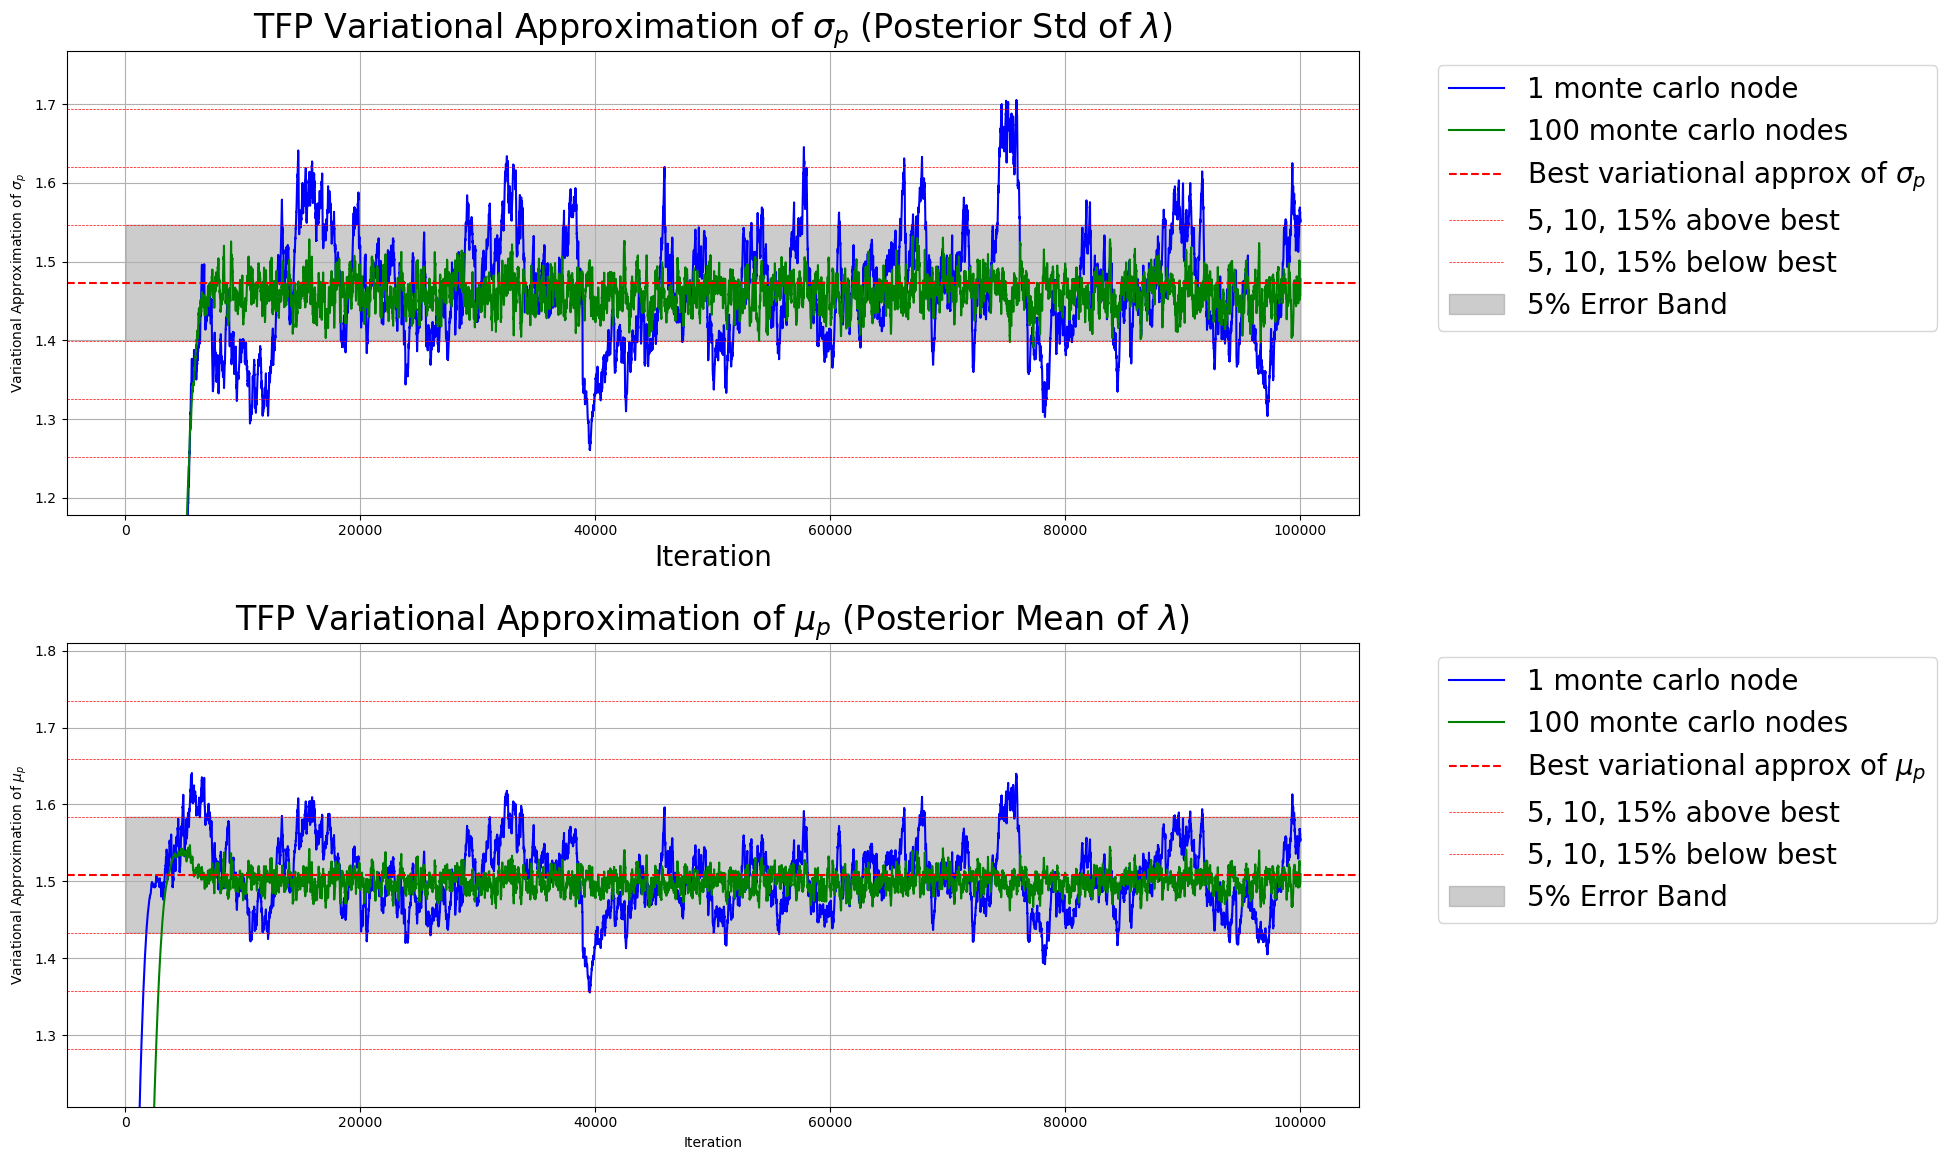

In [8]:
single_mus, single_stds = traces_to_lambda_moments(
    single_tracker[0], single_tracker[1])
multi_mus, multi_stds = traces_to_lambda_moments(
    multi_tracker[0], multi_tracker[1])

best_mu_unc = config['best_mean']
best_sigma_unc = config['best_std']
best_mu, best_sigma = pushforward_exp_mean_std(best_mu_unc, best_sigma_unc)

fig, axs = plt.subplots(2, 1, figsize=(20, 12))
plt.rcParams.update({'font.size': 20})

axs[1].plot(single_mus, label='1 monte carlo node', color='blue')
axs[1].plot(multi_mus, label='100 monte carlo nodes', color='green')

axs[1].axhline(best_mu, color='red', linestyle='--', label=r'Best variational approx of $\mu_p$')
axs[1].set_title(r'TFP Variational Approximation of $\mu_p$ (Posterior Mean of $\lambda$)')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel(r'Variational Approximation of $\mu_p$')
axs[1].grid()

axs[0].plot(single_stds, label='1 monte carlo node', color='blue')
axs[0].plot(multi_stds, label='100 monte carlo nodes', color='green')

axs[0].axhline(best_sigma, color='red', linestyle='--', label=r'Best variational approx of $\sigma_p$')
axs[0].set_title(r'TFP Variational Approximation of $\sigma_p$ (Posterior Std of $\lambda$)')
axs[0].set_xlabel('Iteration', fontsize=20)
axs[0].set_ylabel(r'Variational Approximation of $\sigma_p$')

axs[0].grid()

for i in [5, 10, 15]:
    axs[1].axhline(best_mu * (1 + i/100), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% above best' if i == 5 else None)
    axs[1].axhline(best_mu * (1 - i/100), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% below best' if i == 5 else None)

    axs[0].axhline(best_sigma * (1 + i/100), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% above best' if i == 5 else None)
    axs[0].axhline(best_sigma * (1 - i/100), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% below best' if i == 5 else None)

axs[1].fill_between(range(max_iters), best_mu*0.95, best_mu*1.05, color='gray', alpha=0.4, label='5% Error Band')
axs[0].fill_between(range(max_iters), best_sigma*0.95, best_sigma*1.05, color='gray', alpha=0.4, label='5% Error Band')

axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[0].set_ylim((best_sigma * 0.8, best_sigma * 1.2))
axs[1].set_ylim((best_mu * 0.8, best_mu * 1.2))
plt.tight_layout()
plt.show()